---
### Simplified System of linear equations solving for image $X$

Key terms:

$L$ = one-dimensional size for high-resolution image

$M$ = one-dimensional size for low-resolution image

$X$ = $L^2 \times 1$ column vector, represents the ideal image we are trying to recover via solving

$Y_i$ = $M^2 \times 1$ column vector, represents a decimated, downsampled, blurred, noisy image based on $X$

$N$ = the number of low-resolution images

$D$ = the decimation matrix operator of size $M^2 \times L^2$

$H$ = the blur matrix operator of size $L^2 \times L^2$

$S$ = the sharpening operator of size $L^2 \times L^2$, i.e., the laplacian operator

$w_i$ = a weighting scalar, a "confidence factor" for each $Y_i$ (eventually a diagonal matrix?)

$\beta$ = smoothing factor for controlling image sharpening

---

Objective: to solve for $X$ (i.e., $AX = B$) based on the following equation:

$\begin{bmatrix}
  \beta S^T S + (\sum\limits_{i=1}^N w_i) H^TD^TDH
\end{bmatrix}X = \sum\limits_{i=1}^N (w_iH^TD^TY_i)$

---

General information:

- Dataset: GLEAM Small
- Timesteps: 30
- Receivers: 512
- Channels: 1
- $L$ = 100 pixels
- $M$ = 50 pixels
- $N$ = 6 images (30 timesteps / 5 timesteps per image)
- $w_i$ = 1 for all images
- $\beta$ = 1 (I guess?)

Asumptions:
1. The blur kernel $H$ is uniform across all instances of $Y$
2. The decimatimation kernel $D$ is uniform across all instances of $Y$
3. The $w_i$ is uniform across all instances of $Y$, just a confidence of 1.0 ("full confidence")

---

#### To do:

- [x] Generate 6 dataset subsets, containing timesteps each (i.e., 30 time steps / 5 time steps per file)
- [x] Generate one point spread function per dataset subset, for analysis of different
- [x] Generate one point spread function for the whole dataset
- [x] Determine if there is a significant difference between a subset PSF and the full dataset PSF - this will be the blur kernel
- [ ] Determine if the PSF can be reduced (i.e., dont use the full PSF) - what effects might this have?
- [x] Generate an IDFT of the full dataset, $L^2$ pixels
- [x] Genetate an IDFT for each of the subsets, $M^2$ pixels
- [x] Come up with a formula for populating the decimation matrix
- [ ] Come up with a formula for populating the blur matrix 
- [ ] Determine if there is a formula for populating the product of the blur and decimation matrix, such that $H^TD^T = (HD)^T$
- [ ] take the average of optimal betas across support 20 to 47, use that for all supports, plot the error between solved x and true x using the averaged beta, and compare that against another plot which is the "optimal" beta vs support
- [ ] another thing to try, consider trimming the edge of solved x before taking norms and measuring RRMSE, as the convolution matrices are not padded and so convolution is essentially "incomplete" around the image edges. Probably only need to take say 10-15 pixels off all edges, since most of the PSF is noise aside from the center.
- [ ] Another thing to try is to produce a set of Y images which are only representative of a single source, like a PSF. Then I could run the SOLE algorithm to determine what the effects of solving are against the curve of a point source, by taking a middle slice of the image (like I do when inspecting the actual PSF). Could examine what happens when using different supports and beta terms to see which lines up best with the true curve.
 - [ ] I need to modify the decimation matrix function to support more than just 4 neighbours (or 1/2 decimation).
 - [ ] Modify the project so it is more like a library, where I can call my own functions in my desired order. This would make repeating experiments easier than one flat notebook.
---

In [1]:
%matplotlib inline

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage import data, io, color
from skimage.transform import resize

plt.rcParams['figure.figsize'] = [10, 10]

def show_image(image, title, flip_x_axis=False):
    if flip_x_axis:
        image = np.fliplr(image)
    plt.imshow(image, cmap=plt.get_cmap("gray"))
    plt.title(title)
    plt.colorbar()
    plt.show()
    
def normalise(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def rrmse(observed, ideal, decimal=6):
    return "{:.{}f}".format(np.sqrt((1 / observed.shape[0]**2) * np.sum((observed-ideal)**2) / np.sum(ideal**2)) * 100.0, decimal)

def decimation_matrix(l, m):
    d_matrix = np.zeros((m**2, l**2), dtype=np.float32)

    tile = np.repeat((1, 0, 1), (2, l - 2, 2)) # assuming taking 2 neighbours per dimension
    t_len = tile.shape[0]
    d = l // m
    r_offset = m**2 // 2
    c_offset = l**2 // 2

    for p in np.arange(l//4): # divide by 4 as 4 neighbours total
        p_offset = p * l
        for q in np.arange(m):
            d_matrix[q+ p_offset//2, q*d + p_offset*2 : q*d+t_len + p_offset*2] = tile # top-left quadrant
            d_matrix[q+r_offset + p_offset//2, q*d+c_offset + p_offset*2: q*d+t_len+c_offset + p_offset*2] = tile # bottom-right quadrant
    return d_matrix

# produces convolution matrix of size l**2 by l**2, where each row is populated by the convolution kernel values at the appropriate neighbours
# note: assumes kernel is a two-dimensonal numpy array of some size n by n
def convolution_matrix(l, kernel):
    
    conv = np.zeros((l**2, l**2), dtype=np.float32)
    full_supp = kernel.shape[0] # assumed square
    half_supp = (full_supp - 1) // 2

    for conv_row in np.arange(l**2):

        row, col = (conv_row // l, conv_row % l)

        for k_row in np.arange(-(half_supp), half_supp + 1):
            # map "kernel row" to rows in conv
            mapped_row = row + k_row
            # ignore any out of bounds rows
            if mapped_row >= 0 and mapped_row < l:
                linear_col = col - half_supp
                # truncate negative columns
                mapped_col_start = max(linear_col, 0)
                # truncate columns which exceed the l dimension
                mapped_col_end = min(linear_col + full_supp, l)
                # left trimming for kernels when overlapping out of bounds region in conv (col < 0)
                left = np.absolute(col - half_supp) if linear_col < 0 else 0
                # right trimming for kernels when overlapping out of bounds region in conv (col >= l)
                right = linear_col + full_supp - l if linear_col + full_supp >= l else 0 
                # copy over kernel row for current k_row, possibly including trimming for out of bounds coordinates
                conv[conv_row][mapped_row * l + mapped_col_start : mapped_row * l + mapped_col_end] = kernel[k_row + half_supp][left: left + full_supp - right]
    return conv

#### Configuration and data set up...

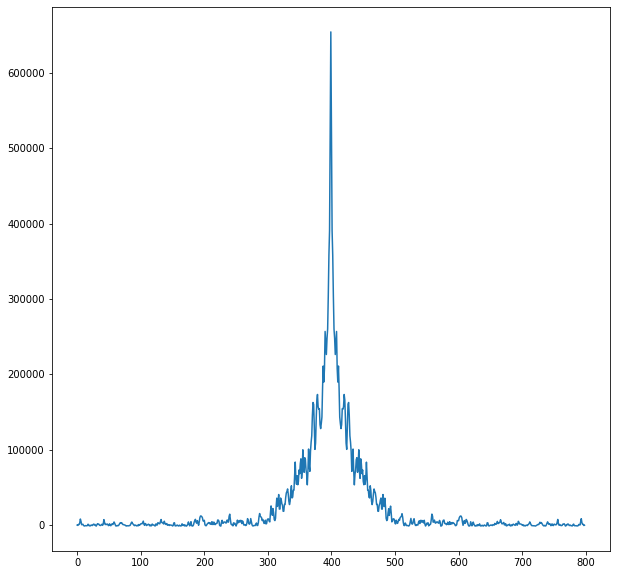

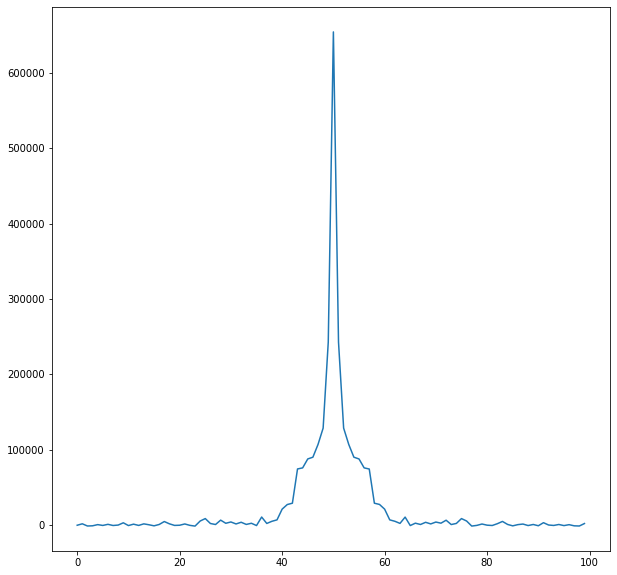

1.0


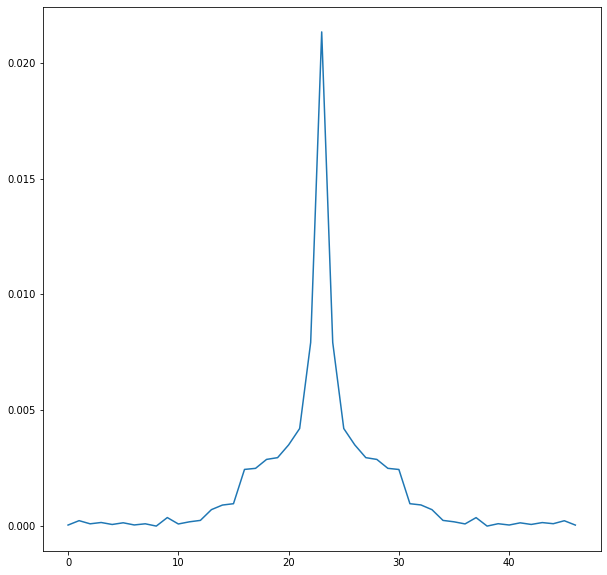

PSF Shape: 47


In [2]:
timesteps = 30 # total timesteps
timesteps_per_y = 5
l = 100
m = 50
n = timesteps // timesteps_per_y
w = np.ones(n)
β = 0.264977485046579

# all time steps direct image
# filename = "../data/direct_image_ts_0_29.bin"
filename = "../data/direct_image_ts_0_29_800x800.bin"
x_true = np.fromfile(filename, dtype=np.float32)
# x_true = np.reshape(x_true, (l, l))
x_true = resize(x_true.reshape(800, 800), (l, l), anti_aliasing=False, order=1)
x_true = normalise(x_true)
# show_image(x_true, "True X (800^2 averaged to 100^2)")

# x_orig = np.fromfile("../data/direct_image_ts_0_29.bin", dtype=np.float32)
# show_image(normalise(x_orig.reshape(l, l)), "Original True X (100^2)")

# all time steps direct psf
# filename = "../data/direct_psf_ts_0_29.bin"
# filename = "../data/direct_psf_ts_0_29_800x800.bin"
# x_psf = np.fromfile(filename, dtype=np.float32)
# x_psf = resize(x_psf.reshape(800, 800), (l, l), anti_aliasing=False, order=1)
# x_psf = x_psf.reshape(l, l)[1:, 1:] # trim row 0 and all column 0 (to ensure odd dimensions with the peak in the center)
# x_psf /= np.max(x_psf)
# show_image(x_psf, "PSF (800^2 averaged to 100^2)")

filename = "../data/direct_psf_ts_0_29_800x800.bin"
x_psf = np.fromfile(filename, dtype=np.float32).reshape(800, 800)[1:, 1:]
plt.plot(x_psf[x_psf.shape[0]//2])
plt.show()
# show_image(x_psf, "Untrimmed PSF")
x_psf = resize(x_psf, (l-1, l-1), anti_aliasing=False, order=1)
x_psf = np.pad(x_psf, ((1, 0), (1, 0))) # pad with new 0th row/col to ensure trimming from centre
# show_image(x_psf, "Untrimmed PSF - RESIZED")
plt.plot(x_psf[x_psf.shape[0]//2])
plt.show()

trim_half_len = 24
psf_min = l//2 - (trim_half_len - 1)
psf_max = l//2 + trim_half_len
# x_psf = x_psf.reshape(l, l)[psf_min:psf_max, psf_min:psf_max]
x_psf = x_psf[psf_min:psf_max, psf_min:psf_max]
x_psf /= np.sum(x_psf)
print(np.sum(x_psf))
plt.plot(x_psf[x_psf.shape[0]//2])
plt.show()

print(f"PSF Shape: {x_psf.shape[0]}")
# show_image(np.log(np.absolute(x_psf)), "PSF")

# Storing all low-res images as layered stack
y = np.zeros((n, m, m))

# batched time steps direct images
for i in np.arange(n):
    filename = f"../data/direct_image_ts_{i * timesteps_per_y}_{i * timesteps_per_y + timesteps_per_y - 1}.bin"
    y[i] = np.fromfile(filename, dtype=np.float32).reshape(m, m)
    y[i] = normalise(y[i])
    # show_image(y[i], f"$Y_{i}$", flip_x_axis=True)
    
# batched time steps point spread functions
# for i in np.arange(N):
#     start = i * timesteps_per_y
#     end = start + timesteps_per_y - 1
#     filename = "../data/direct_psf_ts_%d_%d.bin" % (start, end)
#     Y_i_psf = np.fromfile(filename, dtype=np.float32)
#     Y_i_psf = Y_i_psf.reshape(L, L)
#     # show_image(Y_i_psf, "$Y_{%d}$ PSF" % i)

# Decimation matrix
d = decimation_matrix(l, m) # takes the sum of 4 l neighbours to form 1 m pixel

# Blur matrix (psf)
h = convolution_matrix(l, x_psf)

# Sharpening matrix (laplacian)
laplacian = np.array([[0, -1,  0], [-1,  4, -1], [0, -1,  0]], dtype=np.float32)
s = convolution_matrix(l, laplacian)

#### Setting up the right hand side of the equation $AX = B$, where $B = \sum\limits_{i=1}^N (w_iH^TD^TY_i)$

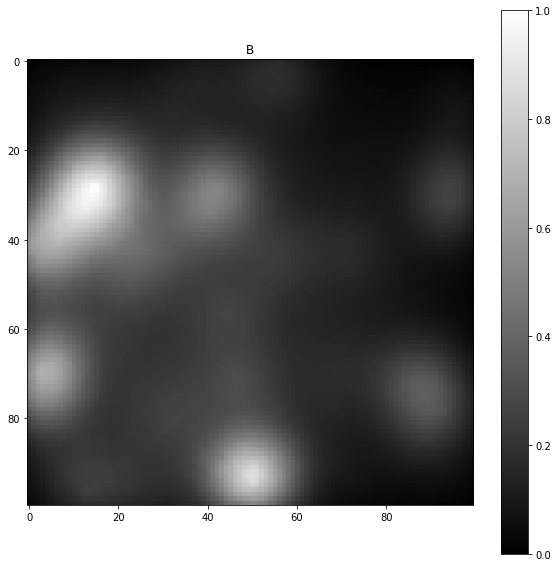

In [3]:
b = np.zeros(l**2, dtype=np.float32)

for i in np.arange(n):
    b += np.matmul(w[i] * h.T, np.matmul(d.T, y[i].flatten()))
                     
show_image(normalise(b.reshape(l, l)), "B")

#### Setting up the right hand side of the equation $AX=B$, where $A = \begin{bmatrix}
  \beta S^T S + (\sum\limits_{i=1}^N w_i) H^TD^TDH
\end{bmatrix}$

In [4]:
lhs = β * np.matmul(s.T, s)
rhs = (h.T @ d.T @ d @ h) * np.sum(w)
a = lhs + rhs
# ow_image(a.reshape(l**2, l**2), "A")

#### Now solve for $X$...

In [5]:
# Solving via CPU and numpy...
# x = np.linalg.solve(a, b)
# x = x.reshape(100, 100)

In [6]:
# Solving via GPU and cupy
a_gpu = cp.asarray(a)
b_gpu = cp.asarray(b)
solution = cp.linalg.solve(a_gpu, b_gpu)
x = cp.asnumpy(solution)
x = x.reshape(100, 100)

# Dealloc cuda mem
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()

RRMSE: Solved X and True X -> 1.134463
Beta: 0.264977485046579
A_laplacian l1 norm: 16.958560943603516
A_laplacian linf norm: 16.958560943603516
A_deci_blur l1 norm: 24.000049591064453
A_deci_blur linf norm: 24.000001907348633
A_deci_blur / A_laplacian l1 ratio: 1.415217399597168
A_deci_blur / A_laplacian linf ratio: 1.4152145385742188


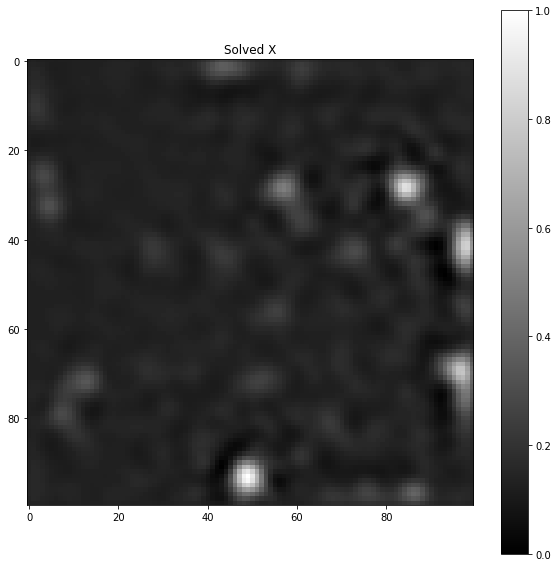

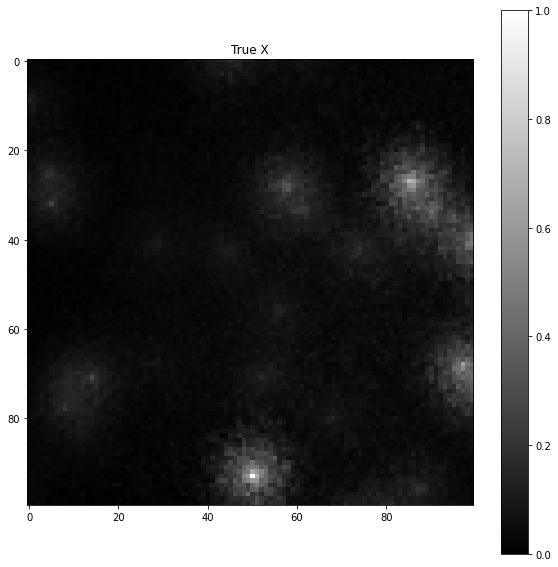

In [7]:
# b_true = np.matmul(normalise(a), x_true.flatten())
# x_accurate = np.linalg.solve(a, b_true)
# x_accurate = x_accurate.reshape(100, 100)

# show_image(normalise(x), "Solved X")
# print(f"RRMSE: B and True B -> {rrmse(normalise(b.reshape(l, l)), normalise(b_true.reshape(l, l)))}")
# print(f"L2 between B and True X: {np.sqrt(np.sum((normalise(b.reshape(l, l))-normalise(x))**2))}")
# show_image(normalise(b.reshape(l, l)), "B")
# show_image(normalise(b_true.reshape(l, l)), "True B")

# print(f"RRMSE: X and Accurate X -> {rrmse(normalise(x), normalise(x_accurate))}")
# print(f"RRMSE: Accurate X and True X -> {rrmse(normalise(x_accurate), normalise(x_true))}")
print(f"RRMSE: Solved X and True X -> {rrmse(normalise(x), normalise(x_true))}")
print(f"Beta: {β}")

# Multiply A left hand side (beta and sharpening matrices) by X
a_laplacian = lhs # np.matmul(lhs, x.flatten()).reshape(l, l)
# show_image((a_laplacian), "A-laplacian", flip_x_axis=True)
a_lap_l1 = np.max(np.sum(np.absolute(a_laplacian), axis=0))
a_lap_linf = np.max(np.sum(np.absolute(a_laplacian), axis=1))
print(f"A_laplacian l1 norm: {a_lap_l1}")
print(f"A_laplacian linf norm: {a_lap_linf}")

a_deci_blur = rhs # np.matmul(rhs, x.flatten()).reshape(l, l)
# show_image((a_deci_blur), "A-deci-blur", flip_x_axis=True)
a_dec_l1 = np.max(np.sum(np.absolute(a_deci_blur), axis=0))
a_dec_linf = np.max(np.sum(np.absolute(a_deci_blur), axis=1))
print(f"A_deci_blur l1 norm: {a_dec_l1}")
print(f"A_deci_blur linf norm: {a_dec_linf}")

print(f"A_deci_blur / A_laplacian l1 ratio: {a_dec_l1 / a_lap_l1}")
print(f"A_deci_blur / A_laplacian linf ratio: {a_dec_linf / a_lap_linf}")

show_image(normalise(x), "Solved X", flip_x_axis=True)
# show_image(normalise(x_accurate[10:l-11, 10:l-11]), "Solved X using True X (IDFT)")
# show_image(normalise(x_accurate), "Solved X using True X (IDFT)")
show_image(normalise(x_true), "True X", flip_x_axis=True)
# show_image(normalise(a_laplacian + a_deci_blur), "A parts summed to B", flip_x_axis=True)

#### Notes to self:

- If one takes the $\beta S^T S$ portion of $A$ and multiplies it by the solved $X$;  assuming the result is not normalised, one can observe the contribution of beta-influenced laplacian sharpening towards $B$. It appears to float around 10% of the second portion of $A$ (the decimated PSF) multiplied by the solved $X$. Taking the sum of these two separate portions of $AX$ allow one to produce $B$. It appears that the laplacian sharpening portion of $A$ does meaningfully contribute to help find a reasonable solution to $X$, and doesnt appear to be dominating (i.e., drowning out) the decimated PSF portion of $A$.
- Essentially, we dont want the beta-driven laplacian to dominate the sharpened PSF, otherwise you end up with effectively an overly smooth image $X$, and the technique becomes less useful / less impressive. We want to solve for $X$, such that beta helps us resolve a more accurate image $X$ which isnt just noise (a lack of structure, looks like static), and also doesnt look too smooth. If solving was less useful because we required large beta terms, then we might as well just average our set of $Y$ low-resolution images instead since its computationally cheaper?